# Train MolDecod - Decoder-only transformer with rotary positional encoding for molecule generation

This is the end-to-end notebook to train and evaluate MolDecod, a small decoder-only transformer for generating molecules represented as SMILES, and its tokenizer (using SentencePiece).

The entire notebook takes ~5 hours to run on an NVIDIA A100.

### Data

We train the model on a combination of two datasets for molecule generation (cf [here](https://tdcommons.ai/generation_tasks/molgen/)):
- MOSES, a benchmark platform for distribution learning based molecule generation, processed from the ZINC Clean Leads dataset, containing ~ 2 million molecules.
- ChEMBL, a manually curated database of bioactive molecules with drug-like properties, containing ~ 2 million molecules.

The split results in 2.7 million molecules in the training set, and ~600k molecules in both the validation and test sets.

### Result

The final model has 5 million parameters and is very performant for its size.

On 10,000 generated molecules:
- Validity: 0.95
- Uniqueness: 0.95
- Diversity: 0.87
- Novelty: 0.93

## Setup

In [ ]:
# pip install torch scikit-learn PyTDC rdkit-pypi sentencepiece

In [2]:
import math
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from rdkit import Chem
import sentencepiece as spm

# Check if GPU is available
cuda_available = torch.cuda.is_available()

if cuda_available:
    print("CUDA is available.")
    print(f"Number of GPUs available: {torch.cuda.device_count()}")

    for i in range(torch.cuda.device_count()):
        print(f"Device {i+1}: {torch.cuda.get_device_name(i)}")
        print(f"  - Total Memory: {torch.cuda.get_device_properties(i).total_memory / (1024 ** 3):.2f} GB")
        print(f"  - Multiprocessors: {torch.cuda.get_device_properties(i).multi_processor_count}")
        print(f"  - Compute Capability: {torch.cuda.get_device_properties(i).major}.{torch.cuda.get_device_properties(i).minor}")
else:
    print("CUDA is not available.")

# Use GPU if available, CPU if not
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Pre-define seed for reproducibility
seed = 42
torch.manual_seed(seed)
if cuda_available:
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

CUDA is available.
Number of GPUs available: 1
Device 1: NVIDIA A100-SXM4-80GB
  - Total Memory: 79.32 GB
  - Multiprocessors: 108
  - Compute Capability: 8.0
Using device: cuda


## Data

We import, concatenate and re-split MOSES and ChEMBL, because the original validation set was too small and led to overfitting.

You can also specify a path, where to save the data by specifiying:
- `path = ''`
- `data_source = MolGen(name=source_name, path=path)`

In [3]:
from tdc.generation import MolGen

# Get MolGen datasets, and split 70/15/15 (train/validation/test)
def load_and_prepare_data(source_name, test_size=0.15, val_size=0.1765, random_state=42):
    # Initialize and get data splits
    data_source = MolGen(name=source_name)
    split_data = data_source.get_split()

    # Combine train, valid, and test into a single DataFrame and drop NaNs
    df = pd.concat([split_data['train'], split_data['valid'], split_data['test']], ignore_index=True)
    df.dropna(subset=['smiles'], inplace=True)

    # Train-validation-test split
    train_val, test = train_test_split(df, test_size=test_size, random_state=random_state)
    train, valid = train_test_split(train_val, test_size=val_size, random_state=random_state)
    
    return train, valid, test

# Load and prepare datasets
train_moses, valid_moses, test_moses = load_and_prepare_data('MOSES')
train_chembl, valid_chembl, test_chembl = load_and_prepare_data('ChEMBL')

# Concatenate the two sources
train_df = pd.concat([train_moses, train_chembl], ignore_index=True)
valid_df = pd.concat([valid_moses, valid_chembl], ignore_index=True)
test_df = pd.concat([test_moses, test_chembl], ignore_index=True)

# Display the first few entries and shapes of datasets
print(train_df.head())
print(f"Train set shape: {train_df.shape}")
print(f"Validation set shape: {valid_df.shape}")
print(f"Test set shape: {test_df.shape}")

Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!


                                   smiles
0           COCCOCC1NCCc2cc3ccc(O)cc3cc21
1     Cc1ccc(NC(=O)N2CCCC2C(O)C(F)(F)F)s1
2  COc1ccc(C(C)NC(=O)CCn2cc(C)cn2)c(OC)c1
3   COc1ccc(Cl)cc1-c1ccc(C#N)c(=O)n1C(C)C
4         O=C(c1cc(-n2cccn2)ccn1)N1CCOCC1
Train set shape: (2714758, 1)
Validation set shape: (581853, 1)
Test set shape: (581756, 1)


## Tokenizer

We train a SentencePiece tokenizer, with a vocab size of 1000.

In [4]:
# Special tokens
SOS_TOKEN = '<SOS>'  # start of sequence
EOS_TOKEN = '<EOS>'  # end of sequence
PAD_TOKEN = '<PAD>'  # padding

In [4]:
# Prepare SMILES data for SentencePiece tokenizer
def prepare_smiles_file(dataframe, file_name='train_smiles.txt'):
    smiles_strings = dataframe['smiles'].tolist()
    with open(file_name, 'w') as f:
        for smile in smiles_strings:
            mol = Chem.MolFromSmiles(smile)
            if mol is not None:
                canonical_smile = Chem.MolToSmiles(mol, canonical=True)
                f.write(canonical_smile + '\n')  # Write each SMILES on a new line
            else:
                print(f"Invalid SMILES string: {smile}")

# Prepare training data (creates 'train_smiles.txt')
prepare_smiles_file(train_df, 'train_smiles.txt')

# Train and save SentencePiece tokenizer model
spm.SentencePieceTrainer.Train(input='train_smiles.txt', model_prefix='smiles', vocab_size=1000, user_defined_symbols=[EOS_TOKEN, PAD_TOKEN, SOS_TOKEN])

[21:42:16] WARNING: not removing hydrogen atom without neighbors
[21:42:27] WARNING: not removing hydrogen atom without neighbors
[21:42:36] WARNING: not removing hydrogen atom without neighbors
[21:43:31] WARNING: not removing hydrogen atom without neighbors
[21:43:31] WARNING: not removing hydrogen atom without neighbors
[21:43:31] WARNING: not removing hydrogen atom without neighbors
[21:44:25] WARNING: not removing hydrogen atom without neighbors
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: train_smiles.txt
  input_format: 
  model_prefix: smiles
  model_type: UNIGRAM
  vocab_size: 1000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits:

In [5]:
# Load SentencePiece tokenizer model
sp = spm.SentencePieceProcessor()
sp.load('smiles.model')

# Dataset Class
class SMILESDataset(Dataset):
    def __init__(self, dataframe, sp_model):
        self.smiles = dataframe['smiles'].tolist()
        self.sp = sp_model

        # Process SMILES using the tokenizer
        self.processed_smiles = []
        for smile in self.smiles:
            mol = Chem.MolFromSmiles(smile)
            if mol is not None:  # Ensure valid SMILES
                canonical_smile = Chem.MolToSmiles(mol, canonical=True)
                self.processed_smiles.append(canonical_smile)
            else:
                print(f"Invalid SMILES string: {smile}")

    def __len__(self):
        return len(self.processed_smiles)

    def __getitem__(self, idx):
        smile = self.processed_smiles[idx]
        # Tokenize
        tokens = [self.sp.piece_to_id(SOS_TOKEN)] + self.sp.encode(smile) + [self.sp.piece_to_id(EOS_TOKEN)]
        return torch.tensor(tokens, dtype=torch.long)

# Custom collate function for padding sequences
def collate_fn(batch):
    batch = [item for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=sp.piece_to_id(PAD_TOKEN))
    return batch

# Dataset setup
train_dataset = SMILESDataset(train_df, sp)
valid_dataset = SMILESDataset(valid_df, sp)
test_dataset = SMILESDataset(test_df, sp)

[11:34:43] WARNING: not removing hydrogen atom without neighbors
[11:34:54] WARNING: not removing hydrogen atom without neighbors
[11:35:02] WARNING: not removing hydrogen atom without neighbors
[11:35:56] WARNING: not removing hydrogen atom without neighbors
[11:35:56] WARNING: not removing hydrogen atom without neighbors
[11:35:56] WARNING: not removing hydrogen atom without neighbors
[11:36:48] WARNING: not removing hydrogen atom without neighbors


In [14]:
# Calculate the number of tokens in the dataset
def calculate_total_tokens(dataset):
    total_tokens = 0
    for i in range(len(dataset)):
        tokens = dataset[i]
        total_tokens += len(tokens)
    return total_tokens

total_train_tokens = calculate_total_tokens(train_dataset)
total_valid_tokens = calculate_total_tokens(valid_dataset)
total_test_tokens = calculate_total_tokens(test_dataset)

print(f"Total number of tokens in training dataset: {total_train_tokens}")
print(f"Total number of tokens in validation dataset: {total_valid_tokens}")
print(f"Total number of tokens in test dataset: {total_test_tokens}")

Total number of tokens in training dataset: 96855925
Total number of tokens in validation dataset: 20757282
Total number of tokens in test dataset: 20727137


## Model

This is where we define the model architecture, particularly the rotary positional encoding and the decoder-only transformer, as well as the hyperparameters.

In [6]:
class RotaryPositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(RotaryPositionalEncoding, self).__init__()
        self.d_model = d_model
        self.dropout = nn.Dropout(p=dropout)
        
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        self.register_buffer('sin_pos', torch.sin(position * div_term))
        self.register_buffer('cos_pos', torch.cos(position * div_term))

    def forward(self, x):
        seq_len = x.size(1)
        x1 = x[..., ::2]
        x2 = x[..., 1::2]
        x = torch.cat([
            x1 * self.cos_pos[:seq_len] - x2 * self.sin_pos[:seq_len],
            x1 * self.sin_pos[:seq_len] + x2 * self.cos_pos[:seq_len]
        ], dim=-1)
        return self.dropout(x)

class DecoderOnlyTransformer(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, num_layers, dropout=0.1):
        super(DecoderOnlyTransformer, self).__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = RotaryPositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward=4*d_model, dropout=dropout, activation='gelu', batch_first=True, norm_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.fc_out = nn.Linear(d_model, vocab_size)
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, src, src_mask=None):
        src = self.embedding(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, mask=src_mask)
        output = self.fc_out(output)
        return self.dropout(output)

In [7]:
# Hyperparameters
vocab_size = sp.get_piece_size()  # Use the tokenizer to get the vocabulary size
d_model = 256
nhead = 4
num_encoder_layers = 4
dropout = 0.25

model = DecoderOnlyTransformer(vocab_size, d_model, nhead, num_layers=num_encoder_layers, dropout=dropout)
model = model.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)

## Training

In [18]:
# Training setup
num_epochs = 8
batch_size = 64
clip_value = 1.0  # gradient clipping

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(valid_dataset, batch_size=batch_size, collate_fn=collate_fn)

# OneCycleLR Scheduler setup
total_steps = len(train_dataloader) * num_epochs
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1e-3,  # Peak learning rate
    total_steps=total_steps,
    anneal_strategy='linear',
    final_div_factor=10,  # Final learning rate will be max_lr/div_factor
    pct_start=0.3  # Percentage of the cycle to spend increasing the learning rate
)

def create_mask(size):
    mask = torch.triu(torch.ones(size, size) * float('-inf'), diagonal=1)
    return mask

def train(model, dataloader, criterion, optimizer, scheduler, sp):
    model.train()
    total_loss = 0
    for batch in dataloader:
        batch = batch.to(device)
        optimizer.zero_grad()
        src = batch[:, :-1]
        tgt = batch[:, 1:]
        src_mask = create_mask(src.size(1)).to(device)
        output = model(src, src_mask)
        loss = criterion(output.contiguous().view(-1, sp.get_piece_size()), tgt.contiguous().view(-1))
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip_value)
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def validate(model, dataloader, criterion, sp):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)
            src = batch[:, :-1]
            tgt = batch[:, 1:]
            src_mask = create_mask(src.size(1)).to(device)
            output = model(src, src_mask)
            loss = criterion(output.contiguous().view(-1, sp.get_piece_size()), tgt.contiguous().view(-1))
            total_loss += loss.item()
    return total_loss / len(dataloader)

best_val_loss = float('inf')
best_model_path = 'best_model_.pth'

train_losses = []
val_losses = []

# Training Loop
for epoch in range(num_epochs):
    train_loss = train(model, train_dataloader, criterion, optimizer, scheduler, sp)
    val_loss = validate(model, val_dataloader, criterion, sp)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': val_loss,
        }, best_model_path)
        print(f'Saved the best model with val loss: {val_loss:.4f}')

Epoch 1, Train Loss: 1.8720, Val Loss: 0.4792
Saved the best model with val loss: 0.4792
Epoch 2, Train Loss: 1.6791, Val Loss: 0.4437
Saved the best model with val loss: 0.4437
Epoch 3, Train Loss: 1.6650, Val Loss: 0.4346
Saved the best model with val loss: 0.4346
Epoch 4, Train Loss: 1.6549, Val Loss: 0.4238
Saved the best model with val loss: 0.4238
Epoch 5, Train Loss: 1.6470, Val Loss: 0.4134
Saved the best model with val loss: 0.4134
Epoch 6, Train Loss: 1.6414, Val Loss: 0.4077
Saved the best model with val loss: 0.4077
Epoch 7, Train Loss: 1.6354, Val Loss: 0.4007
Saved the best model with val loss: 0.4007
Epoch 8, Train Loss: 1.6304, Val Loss: 0.3952
Saved the best model with val loss: 0.3952


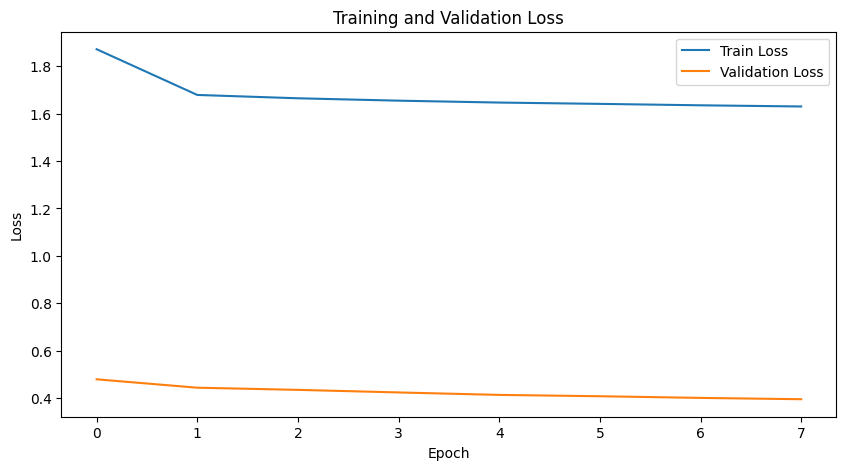

In [19]:
# plot the losses
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [20]:
def count_parameters(model):
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in model.parameters())
    return trainable_params, total_params

trainable, total = count_parameters(model)
print(f"The model has {trainable:,} trainable parameters")
print(f"The model has {total:,} total parameters")

The model has 3,672,040 trainable parameters
The model has 3,672,040 total parameters


In [7]:
# Count the number of parameters using state_dict, to include all parameters (trainable and non-trainable) and buffers
state_dict = model.state_dict()
total_params_state_dict = sum(v.numel() for v in state_dict.values())
print(f"The model has {total_params_state_dict:,} parameters in total (using state_dict)")

The model has 4,952,040 parameters in total (using state_dict)


## Load and evaluate model

In [8]:
# Load the best model checkpoint
checkpoint = torch.load('best_model_mid.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

def create_mask(size):
    mask = torch.triu(torch.ones(size, size) * float('-inf'), diagonal=1)
    return mask

def generate_molecule(model, start_seq, sp_model, max_length=150, temperature=0.7):
    model.eval()
    with torch.no_grad():
        current_seq = start_seq.to(device).unsqueeze(0)  # Add batch dimension
        for _ in range(max_length):
            src_mask = create_mask(current_seq.size(1)).to(device)
            output = model(current_seq, src_mask)
            logits = output[0, -1, :] / temperature  # Select last time step
            next_token_idx = torch.multinomial(torch.softmax(logits, dim=-1), 1).item()
            
            if next_token_idx == sp_model.piece_to_id('<EOS>'):
                break

            next_token_tensor = torch.tensor([[next_token_idx]], device=device)
            current_seq = torch.cat([current_seq, next_token_tensor], dim=1)
    
    # Decode using the tokenizer
    generated_sequence = sp_model.decode_ids(current_seq[0].cpu().tolist())
    return generated_sequence.replace('<SOS>', '', 1)

# Example: Generate a molecule starting with a carbon atom
start_seq = torch.tensor([sp.piece_to_id('<SOS>'), sp.piece_to_id('C')], device=device)  # Start with <SOS> and a carbon atom
generated_molecule = generate_molecule(model, start_seq, sp)
print("Generated molecule:", generated_molecule)

Generated molecule: COc1cc2cc(OC)c(OC)cc2cc1C(c1ccccc1)c1ccccc1


In [22]:
# Evaluate on test set
batch_size = 64

def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)
            src = batch[:, :-1]
            tgt = batch[:, 1:]
            src_mask = create_mask(src.size(1)).to(device)
            output = model(src, src_mask)
            loss = criterion(output.contiguous().view(-1, sp.get_piece_size()), tgt.contiguous().view(-1))
            total_loss += loss.item()
    return total_loss / len(dataloader)

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn)

test_loss = evaluate(model, test_dataloader, criterion)
print(f'Test Loss: {test_loss:.4f}')

Test Loss: 0.3968


In [9]:
# Generate a large set of molecules (e.g., 10,000 or 30,000)
generated_smiles = []
for i in range(10000):
    start_seq = torch.tensor([sp.piece_to_id('<SOS>'), sp.piece_to_id('C')], device=device)  # Start with <SOS> and a carbon atom
    generated_molecule = generate_molecule(model, start_seq, sp)
    generated_molecule = generated_molecule  # Remove start of sequence token
    generated_smiles.append(generated_molecule)
    
    # Print every 1000th molecule
    if (i + 1) % 1000 == 0:
        print(f"Generated molecule {i + 1}: {generated_molecule}")
        
# Get the training and test set SMILES
train_smiles = train_dataset.processed_smiles
test_smiles = test_dataset.processed_smiles

Generated molecule 1000: C(CC)C(=O)Nc1cc(C(=O)NCc2ccccc2)n(C)n1
Generated molecule 2000: C(CO)NC(=O)c1cccc(S(=O)(=O)N2CCCC2)c1
Generated molecule 3000: COc1ccc(C(=O)Nc2cccnc2N2CCCC2)cc1OCC
Generated molecule 4000: Cn1nnc(C(=O)Nc2ccc(OCC(N)=O)cc2)c1C1CC1
Generated molecule 5000: Cn1c(SCC(=O)O)nnc1-c1cccs1
Generated molecule 6000: COc1ccc(C(=O)Nc2ccccc2O)cc1Cl
Generated molecule 7000: Cn1c(SCC(=O)Nc2cccc(OC)c2)nnc1-c1ccc(C)cc1
Generated molecule 8000: C(NC(=O)COCc1ccccc1)c1ccc(F)cc1
Generated molecule 9000: C(=O)N1CCn2c(nnc2-c2ccc(C)cc2)C1
Generated molecule 10000: C1CCCN(C(=O)CCCNC(=O)c2cccnc2OC)C1


In [10]:
from tdc import Evaluator

# Validity
validity_evaluator = Evaluator(name='Validity')
validity_score = validity_evaluator(generated_smiles)
print(f"Validity: {validity_score:.2f}")

# Uniqueness
uniqueness_evaluator = Evaluator(name='Uniqueness')
uniqueness_score = uniqueness_evaluator(generated_smiles)
print(f"Uniqueness: {uniqueness_score:.2f}")

# Diversity
diversity_evaluator = Evaluator(name='Diversity')
diversity_score = diversity_evaluator(generated_smiles)
print(f"Diversity: {diversity_score:.2f}")

Validity: 0.95
Uniqueness: 0.95
Diversity: 0.87


In [11]:
from rdkit.Chem.Scaffolds import MurckoScaffold
from scipy.stats import entropy
from collections import Counter

# Convert SMILES to RDKit molecules
def smiles_to_mol(smiles_list):
    return [Chem.MolFromSmiles(smiles) for smiles in smiles_list if Chem.MolFromSmiles(smiles)]

generated_mols = smiles_to_mol(generated_smiles)
train_mols = smiles_to_mol(train_smiles)

# Novelty
def calculate_novelty(generated_mols, train_mols):
    train_smiles_set = set(Chem.MolToSmiles(mol) for mol in train_mols)
    novel_count = sum(1 for mol in generated_mols if Chem.MolToSmiles(mol) not in train_smiles_set)
    return novel_count / len(generated_mols)

novelty = calculate_novelty(generated_mols, train_mols)
print(f"Novelty: {novelty:.4f}")

# KL Divergence (using molecular weight as an example property)
def calculate_kl_divergence(generated_mols, train_mols):
    def get_mol_weights(mols):
        return [Chem.Descriptors.ExactMolWt(mol) for mol in mols]
    
    gen_weights = get_mol_weights(generated_mols)
    train_weights = get_mol_weights(train_mols)
    
    # Create histograms
    hist_gen, _ = np.histogram(gen_weights, bins=50, density=True)
    hist_train, _ = np.histogram(train_weights, bins=50, density=True)
    
    # Add small epsilon to avoid division by zero
    hist_gen = hist_gen + 1e-10
    hist_train = hist_train + 1e-10
    
    return entropy(hist_gen, hist_train)

kl_divergence = calculate_kl_divergence(generated_mols, train_mols)
print(f"KL Divergence: {kl_divergence:.4f}")

# Fragment Similarity
def calculate_fragment_similarity(generated_mols, train_mols):
    def get_fragments(mol):
        return set(Chem.MolToSmiles(frag) for frag in Chem.GetMolFrags(mol, asMols=True))
    
    train_fragments = set.union(*[get_fragments(mol) for mol in train_mols])
    
    similarities = []
    for mol in generated_mols:
        gen_fragments = get_fragments(mol)
        if gen_fragments:
            similarity = len(gen_fragments.intersection(train_fragments)) / len(gen_fragments)
            similarities.append(similarity)
    
    return np.mean(similarities)

fragment_similarity = calculate_fragment_similarity(generated_mols, train_mols)
print(f"Fragment Similarity: {fragment_similarity:.4f}")

# Scaffold Diversity
def calculate_scaffold_diversity(mols):
    scaffolds = [Chem.MolToSmiles(MurckoScaffold.GetScaffoldForMol(mol)) for mol in mols]
    scaffold_counts = Counter(scaffolds)
    return len(scaffold_counts) / len(mols)

scaffold_diversity = calculate_scaffold_diversity(generated_mols)
print(f"Scaffold Diversity: {scaffold_diversity:.4f}")

[12:07:46] WARNING: not removing hydrogen atom without neighbors
[12:07:46] WARNING: not removing hydrogen atom without neighbors
[12:08:00] WARNING: not removing hydrogen atom without neighbors
[12:08:00] WARNING: not removing hydrogen atom without neighbors
[12:08:09] WARNING: not removing hydrogen atom without neighbors
[12:08:09] WARNING: not removing hydrogen atom without neighbors
[12:09:13] WARNING: not removing hydrogen atom without neighbors
[12:09:13] WARNING: not removing hydrogen atom without neighbors
[12:09:13] WARNING: not removing hydrogen atom without neighbors
[12:09:13] WARNING: not removing hydrogen atom without neighbors
[12:09:13] WARNING: not removing hydrogen atom without neighbors
[12:09:13] WARNING: not removing hydrogen atom without neighbors
[12:10:17] WARNING: not removing hydrogen atom without neighbors
[12:10:17] WARNING: not removing hydrogen atom without neighbors


Novelty: 0.9253
KL Divergence: 5.8839
Fragment Similarity: 0.0767
Scaffold Diversity: 0.6607
